In [1]:
pip install wandb
# wandb api key
# 11285b6f2d5fee811f04dbb1ad087d554bbf15bb

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [16]:
import pandas as pd
import numpy as np
import wandb
import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix, classification_report

In [10]:
# load dataset
file_path = "data_processed.csv"
df = pd.read_csv(file_path)

drop_cols = ["Flow ID", "Source IP", "Destination IP", "Timestamp"]
df.drop(columns=drop_cols, errors="ignore", inplace=True)

categorical_features = ["Source Port", "Destination Port"]
for col in categorical_features:
    freq_map = df[col].value_counts().to_dict()
    df[col] = df[col].map(freq_map)

# encode labels: Convert 'BENIGN' -> 0, 'DDoS' -> 1
label_encoder = LabelEncoder()
df["Label"] = label_encoder.fit_transform(df["Label"])  # Ensures numeric encoding

print("Feature engineering completed.")
# seperating features and labels
X = df.drop(columns=["Label"])
y = df["Label"]

# Train-test stratified split to maintain ratio of classes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Feature engineering completed.


In [12]:
# hyperparameter grids including bias mitigation
param_grids = {
    "Logistic Regression": {
        "C": [0.01, 0.1, 1, 10],
        "class_weight": ["balanced"]  # Bias mitigation
    },
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20],
        "class_weight": ["balanced"]  # Bias mitigation
    },
    "XGBoost": {
        "n_estimators": [50, 100, 200],
        "max_depth": [3, 6, 10],
        "learning_rate": [0.01, 0.1, 0.2]
    },
    "MLP Neural Network": {
        "hidden_layer_sizes": [(64, 32), (128, 64), (256, 128)],
        "max_iter": [300, 500]
    }
}

# Initialize WandB
wandb.init(
    project="DDoS-Detection-Dune",
    config={
        "dataset": "DDoS Network Traffic - Dune",
        "test_size": 0.3,
        "scaling": "StandardScaler",
        "cross_validation_splits": 5
    }
)

# CV setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
tuned_models = {}

Logistic Regression Best Params: {'C': 1, 'class_weight': 'balanced'}


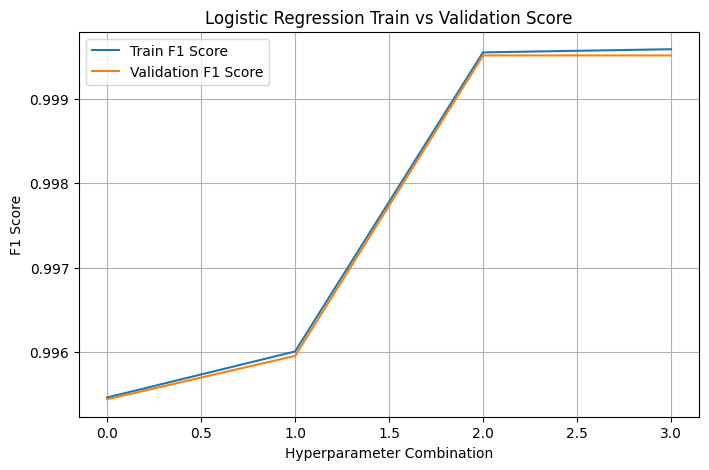

Random Forest Best Params: {'class_weight': 'balanced', 'max_depth': None, 'n_estimators': 50}


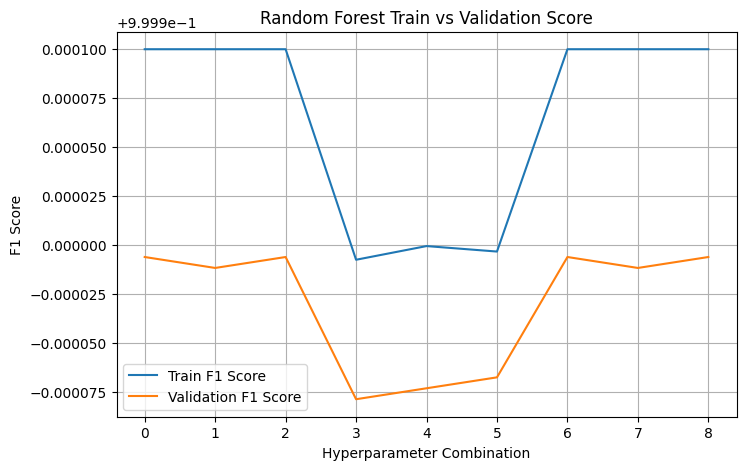

/Users/apurva/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


XGBoost Best Params: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 50}


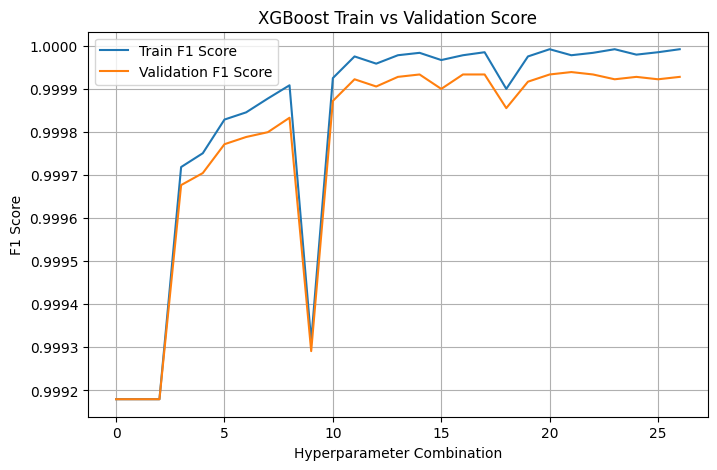

/Users/apurva/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


MLP Neural Network Best Params: {'hidden_layer_sizes': (128, 64), 'max_iter': 300}


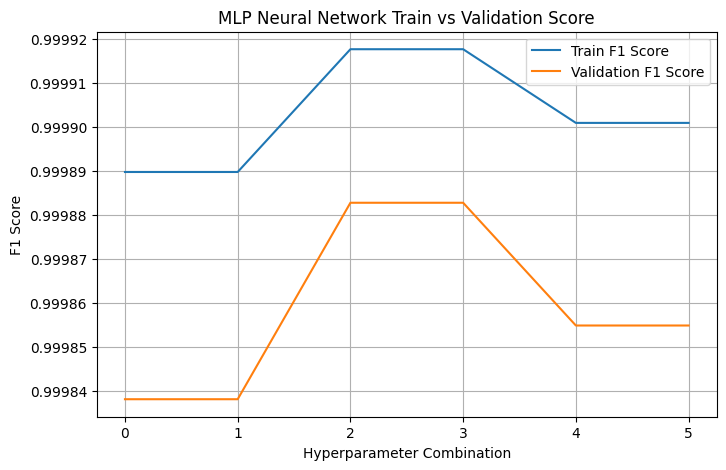

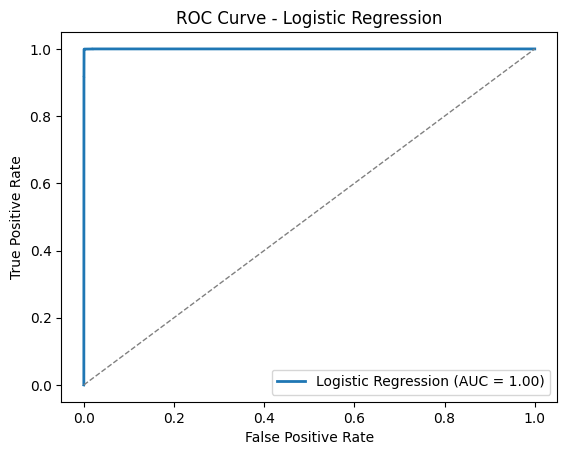

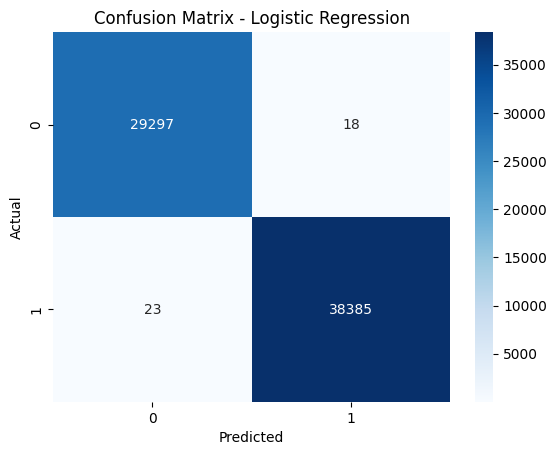

Saved Logistic Regression model and evaluation files in models_run_20250223_184041


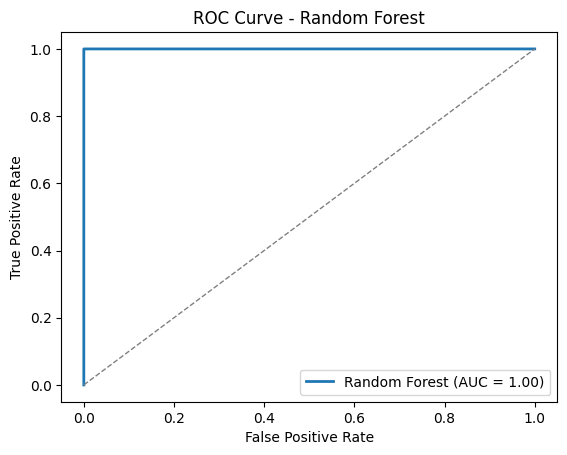

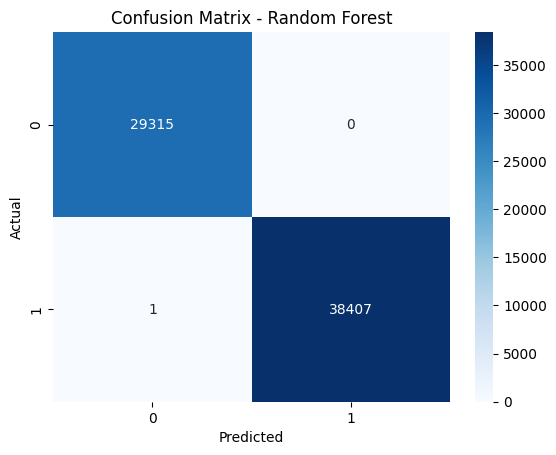

Saved Random Forest model and evaluation files in models_run_20250223_184041


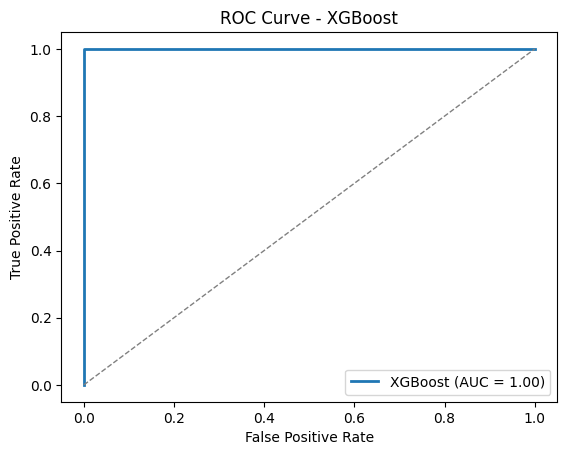

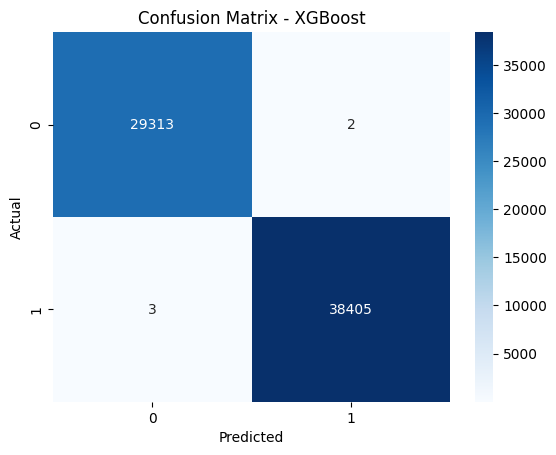

Saved XGBoost model and evaluation files in models_run_20250223_184041


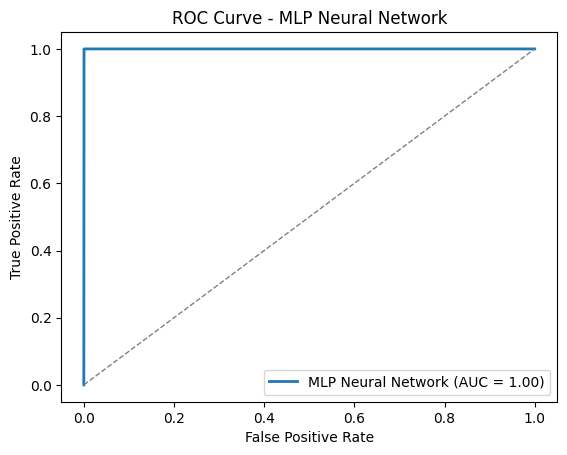

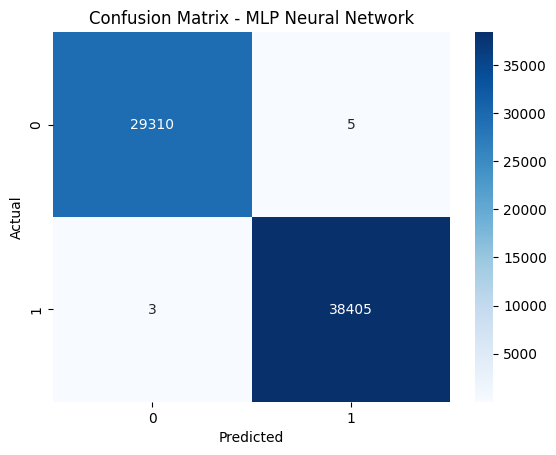

Saved MLP Neural Network model and evaluation files in models_run_20250223_184041


Logistic Regression Accuracy,▁▁▁
Logistic Regression F1 Score,▁▁▁
Logistic Regression Precision,▁
Logistic Regression Recall,▁
MLP Neural Network Accuracy,▁
MLP Neural Network F1 Score,▁
MLP Neural Network Precision,▁
MLP Neural Network Recall,▁
Random Forest Accuracy,▁
Random Forest F1 Score,▁
Random Forest Precision,▁


In [17]:
# Train models using GridSearchCV and log results in WandB
for name, param_grid in param_grids.items():
    model = None
    if name == "Logistic Regression":
        model = LogisticRegression(max_iter=1000)
    elif name == "Random Forest":
        model = RandomForestClassifier(random_state=42)
    elif name == "XGBoost":
        model = XGBClassifier(eval_metric='logloss', random_state=42)
    elif name == "MLP Neural Network":
        model = MLPClassifier(random_state=42)

    # grid Search for Hyperparameter Tuning
    grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='f1', n_jobs=-1, return_train_score=True)
    grid_search.fit(X_train, y_train)
    
    # getting best from Grid Search
    tuned_models[name] = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # logging to wandb
    wandb.config.update({f"{name} Best Params": best_params})
    print(f"{name} Best Params: {best_params}")

    # Train-Test Error Plot
    plt.figure(figsize=(8, 5))
    plt.plot(grid_search.cv_results_['mean_train_score'], label="Train F1 Score")
    plt.plot(grid_search.cv_results_['mean_test_score'], label="Validation F1 Score")
    plt.xlabel("Hyperparameter Combination")
    plt.ylabel("F1 Score")
    plt.title(f"{name} Train vs Validation Score")
    plt.legend()
    plt.grid()

    wandb.log({f"{name} Train-Test Error Plot": wandb.Image(plt.gcf())})
    plt.show()

# Evaluation and Visualization of trained model
run_dir = f"models_run_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}"
os.makedirs(run_dir, exist_ok=True)

for name, model in tuned_models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Logging metrics to wandb
    wandb.log({
        f"{name} Accuracy": accuracy,
        f"{name} Precision": precision,
        f"{name} Recall": recall,
        f"{name} F1 Score": f1
    })

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, y_proba):.2f})", linewidth=2)
    plt.plot([0, 1], [0, 1], linestyle="--", color='gray', linewidth=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend()
    plt.savefig(os.path.join(run_dir, f"roc_curve_{name.replace(' ', '_').lower()}.png"))

    wandb.log({f"{name} ROC Curve": wandb.Image(plt.gcf())})
    plt.show()

    # Conf. Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig(os.path.join(run_dir, f"confusion_matrix_{name.replace(' ', '_').lower()}.png"))

    wandb.log({f"{name} Confusion Matrix": wandb.Image(plt.gcf())})
    plt.show()

    # classification report to understand the metrics
    report = classification_report(y_test, y_pred, output_dict=True)

    # Save model 
    with open(os.path.join(run_dir, f"classification_report_{name.replace(' ', '_').lower()}.txt"), 'w') as f:
        f.write(classification_report(y_test, y_pred))

    joblib.dump(model, os.path.join(run_dir, f"{name.replace(' ', '_').lower()}_model.pkl"))

    print(f"Saved {name} model and evaluation files in {run_dir}")

wandb.finish()

In [18]:
# saving models in run directory
run_dir = f"models_run_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}"
os.makedirs(run_dir, exist_ok=True)

for name, model in tuned_models.items():
    model_path = os.path.join(run_dir, f"{name.replace(' ', '_').lower()}_model.pkl")
    joblib.dump(model, model_path)
    print(f"Saved {name} model at {model_path}")

print(f"All models saved in {run_dir}")

Saved Logistic Regression model at models_run_20250223_184237/logistic_regression_model.pkl
Saved Random Forest model at models_run_20250223_184237/random_forest_model.pkl
Saved XGBoost model at models_run_20250223_184237/xgboost_model.pkl
Saved MLP Neural Network model at models_run_20250223_184237/mlp_neural_network_model.pkl
All models saved in models_run_20250223_184237
